In [261]:
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using ProgressBars
using ProgressMeter
using DataFrames
using CSV
using Base.Threads
gr()

Plots.GRBackend()

In [262]:
Threads.nthreads()

16

# パラメータ

In [263]:
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1
    L = 3
    S = 1 / 2
    J = L - S
    g = 1 + (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (2 * J * (J + 1))
    Jz = [5 / 2, 3 / 2, 1 / 2, -1 / 2, -3 / 2, -5 / 2]
    return J, g, Jz
end
J, g, Jz = ini()

(2.5, 0.8571428571428572, [2.5, 1.5, 0.5, -0.5, -1.5, -2.5])

# Onn 作成関数

In [264]:
function Onn_make(B40)
    #B40 = 0.1167
    B44 = 5 * B40

# O40
    O40_vec = (35 * Jz.^4 - 30 * J * (J + 1) * Jz.^2 + 25 * Jz.^2 .- 6 * J * (J + 1) .+ 3 * J^2 * (J + 1)^2) * B40
    O40 = diagm(0 => O40_vec)

# O44
    O44 = zeros(6, 6)

    Jz_vec_1 = Jz[1] .- collect(0:3)
    O44[5,1] = sqrt(prod(J .+ Jz_vec_1) * prod((J + 1) .- Jz_vec_1)) * B44 / 2

    Jz_vec_2 = Jz[2] .- collect(0:3)
    O44[6,2] = sqrt(prod(J .+ Jz_vec_2) * prod((J + 1) .- Jz_vec_2)) * B44 / 2

    Jz_vec_5 = Jz[5] .+ collect(0:3)
    O44[1,5] = sqrt(prod(J .- Jz_vec_5) * prod((J + 1) .+ Jz_vec_5)) * B44 / 2

    Jz_vec_6 = Jz[6] .+ collect(0:3)
    O44[2,6] = sqrt(prod(J .- Jz_vec_6) * prod((J + 1) .+ Jz_vec_6)) * B44 / 2

    Onn = O40 + O44

    return Onn
end

Onn_make (generic function with 1 method)

# パラメータ(温度,ノイズ強度)

In [265]:
function para()
    
    Temp_table_chi = collect(0.2:0.2:70) # length 350
    n = length(Temp_table_chi)
    noise_chi = 10 #sigma^2 
    
    Temp_table_spc = collect(0.5:0.1:50) # length 496
    m = length(Temp_table_spc)
    noise_spc = 1
    
    return Temp_table_chi, Temp_table_spc, n, m, noise_chi, noise_spc
end

Temp_table_chi, Temp_table_spc, n, m, noise_chi, noise_spc = para()

([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4  …  49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50.0], 350, 496, 10, 1)

# 比熱の値生成

In [266]:
# 比熱
function spc(Onn)
    magfield = 5
    magdir = [1,1,0]
    nor_magdir = magdir / sqrt(sum(magdir.^2))

# 対角要素 0

# 非対角要素
    Hmag_vec_1 = sqrt.((J .+ Jz) .* (J .- Jz .+ 1)) * (nor_magdir[1]+nor_magdir[2]*im)*magfield*g*0.67171/2
    Hmag_vec_1 = Hmag_vec_1[1:5]
    Hmag_1 = diagm(1 => Hmag_vec_1)
    
    Hmag_vec_2 = conj.(Hmag_vec_1)
    Hmag_2 = diagm(-1 => Hmag_vec_2)
    
    Hmag = Hmag_1 + Hmag_2

# 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    SpcHeat_Temp = zeros(m)
    for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        #比熱
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

spc (generic function with 1 method)

# 磁化率の値生成

In [267]:
# 磁化率
function chi(Onn)
    magfield = 0.01
    magdir = [0,0,1]
    nor_magdir = magdir / sqrt(sum(magdir.^2))

# 対角要素
    Hmag_vec_0 = Jz * nor_magdir[3] * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)

# 非対角要素はmagdir[x,y]が0なので0

# 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    chi_inv_Temp = zeros(n)
    for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        for i in 1:6
            eigvec_check = eigvec[:,i]
            mag_z[i] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[i] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

chi (generic function with 1 method)

# データ生成

In [268]:
function making_data()
    true_para = 0.1167
    
    SpcHeat_Temp = spc(Onn_make(true_para))
    SpcHeat_Temp_noise = SpcHeat_Temp + rand([-1,1]) * noise_spc * randn(m)
    
    chi_inv_Temp = chi(Onn_make(true_para))
    chi_inv_Temp_noise = chi_inv_Temp + rand([-1,1]) * noise_chi * randn(n)
    
    return SpcHeat_Temp, SpcHeat_Temp_noise, chi_inv_Temp, chi_inv_Temp_noise
end

making_data (generic function with 1 method)

In [269]:
SpcHeat_Temp, SpcHeat_Temp_noise, chi_inv_Temp, chi_inv_Temp_noise = making_data();

# データ可視化

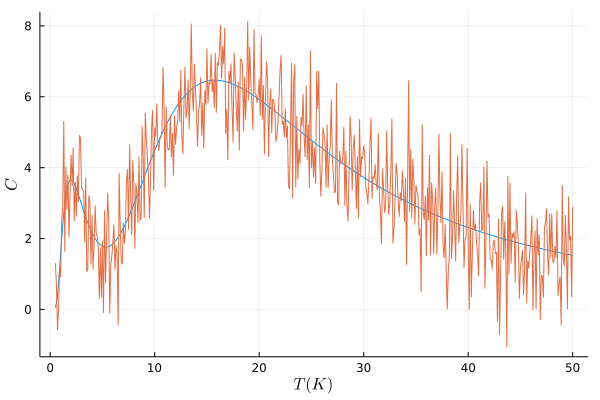

In [270]:
plot(Temp_table_spc, SpcHeat_Temp)
plot!(Temp_table_spc, SpcHeat_Temp_noise)
plot!(xlabel=L"T(K)",ylabel=L"C",legend=false)

In [271]:
#savefig("/Users/nishimurarei/home/lab/data/210930/spc_noise.pdf")

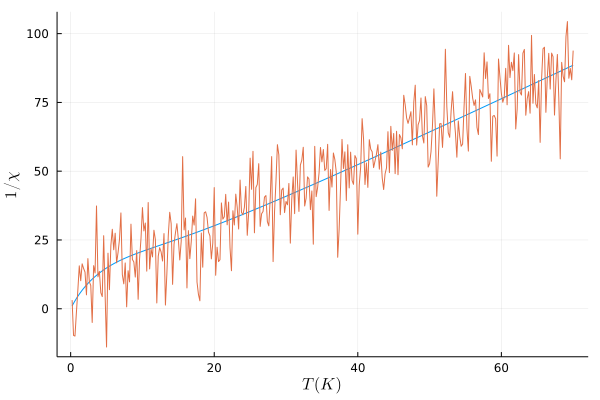

In [272]:
plot(Temp_table_chi, chi_inv_Temp)
plot!(Temp_table_chi, chi_inv_Temp_noise)
plot!(xlabel=L"T(K)",ylabel=L"1/\chi",legend=false)
#noise sigma^2 = 4

In [273]:
#savefig("/Users/nishimurarei/home/lab/data/210930/chi_noise.pdf")

# 誤差最小のパラメータ探索関数

In [274]:
function find_error_min(error_test_list)
    answer_1 = B40_test[argmin(error_test_list)]
    println("大域解:", answer_1)
    println("誤差関数の値", minimum(error_test_list))
    error_test_list_2 = error_test_list[1:Int64(floor(length(B40_test) / 2))]
    answer_2 = B40_test[argmin(error_test_list_2)]
    println("局所解:", answer_2)
    println("誤差関数の値", minimum(error_test_list_2))
    
    return answer_1,answer_2
end

find_error_min (generic function with 1 method)

# 誤差関数 比熱

In [275]:
function error_spc(B40)
    error_value = sum((SpcHeat_Temp_noise - spc(Onn_make(B40))).^2)/(2*m)
    return error_value
end

error_spc (generic function with 1 method)

In [276]:
function error_list_spc(B40_list)
    error_ls = zeros(L)
    @threads for i in 1:L
    #for i in 1:L
        error_value = error_spc(B40_list[i])
        error_ls[i] = error_value
    end
    return error_ls
end

error_list_spc (generic function with 1 method)

# 誤差関数 比熱 可視化

In [290]:
B40_test = collect(-0.5:0.001:0.5)
error_test_list_spc = zeros(length(B40_test))
@threads for i in 1:(length(B40_test))
    error_test_list_spc[i] = error_spc(B40_test[i])
end

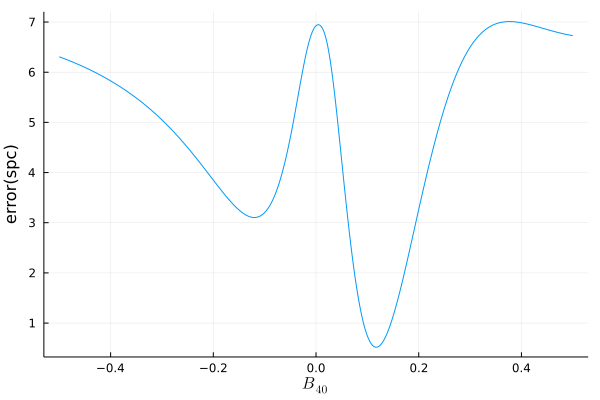

In [291]:
plot(B40_test,error_test_list_spc)
plot!(xlabel=L"B_{40}",ylabel="error(spc)")
plot!(legend=false)

In [292]:
#savefig("/Users/nishimurarei/home/lab/data/210930/error_spc.pdf")

In [293]:
answer_1_spc,answer_2_spc = find_error_min(error_test_list_spc)

大域解:0.117
誤差関数の値0.5192499322236813
局所解:-0.12
誤差関数の値3.1042540793822964


(0.117, -0.12)

# 誤差関数 磁化率

In [294]:
function error_chi(B40)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B40))).^2)/(2*n)
    return error_value
end

error_chi (generic function with 1 method)

In [295]:
function error_list_chi(B40_list)
    error_ls = zeros(L)
    @threads for i in 1:L
        error_value = error_chi(B40_list[i])
        error_ls[i] = error_value
    end
    return error_ls
end

error_list_chi (generic function with 1 method)

# 誤差関数 磁化率 可視化

In [296]:
B40_test = collect(-0.5:0.001:0.5)
error_test_list_chi = zeros(length(B40_test))
@threads for i in 1:(length(B40_test))
    error_test_list_chi[i] = error_chi(B40_test[i])
end

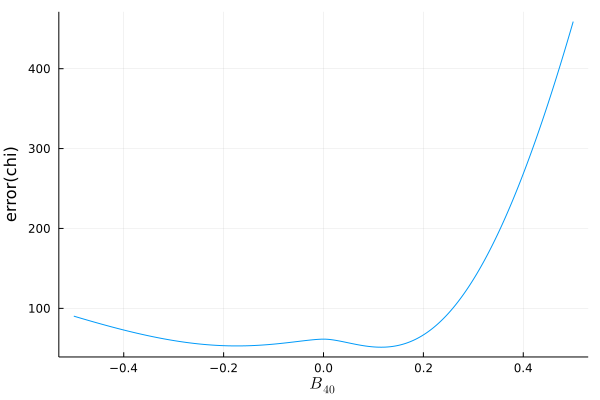

In [297]:
plot(B40_test,error_test_list_chi)
plot!(xlabel=L"B_{40}",ylabel="error(chi)")
plot!(legend=false)

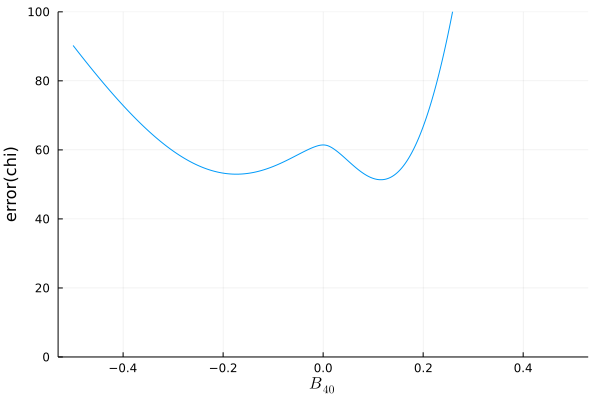

In [299]:
plot(B40_test,error_test_list_chi)
plot!(xlabel=L"B_{40}",ylabel="error(chi)")
plot!(ylims = (0,100))
plot!(legend=false)

In [300]:
#savefig("/Users/nishimurarei/home/lab/data/210930/error_chi.pdf")

In [301]:
answer_1_chi,answer_2_chi = find_error_min(error_test_list_chi)

大域解:0.115
誤差関数の値51.35048414163783
局所解:-0.174
誤差関数の値52.96000181115223


(0.115, -0.174)

# 誤差関数 統合

## パラメータ(統合用の温度,ノイズ強度)

In [398]:
function para_integrate()
    
    n_total = n + m
    noise_total = (noise_chi * noise_spc) / (noise_chi + noise_spc) #逆数の和
    
    return n_total, noise_total
end

n_total, noise_total = para_integrate()

(846, 0.9090909090909091)

In [306]:
function error(B40)
    error_value = (n/n_total) * (noise_total/noise_chi) * error_chi(B40) + (m/n_total) * (noise_total/noise_spc) * error_spc(B40)
    return error_value
end

error (generic function with 1 method)

In [399]:
function error_list(B40_list)
    error_ls = zeros(L)
    @threads for i in 1:L
        error_value = error(B40_list[i])
        error_ls[i] = error_value
    end
    return error_ls
end

error_list (generic function with 1 method)

# 誤差関数 統合 可視化

In [400]:
B40_test = collect(-0.5:0.001:0.5)
error_test_list = zeros(length(B40_test))
@threads for i in 1:(length(B40_test))
    error_test_list[i] = error(B40_test[i])
end

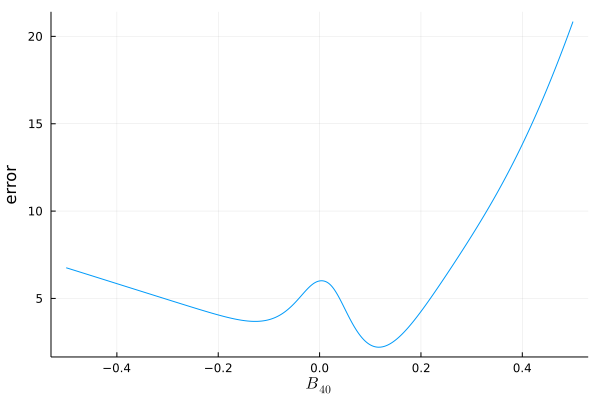

In [401]:
plot(B40_test,error_test_list)
plot!(xlabel=L"B_{40}",ylabel="error")
plot!(legend=false)

In [402]:
savefig("/Users/nishimurarei/home/lab/data/211004/error_integrate.pdf")

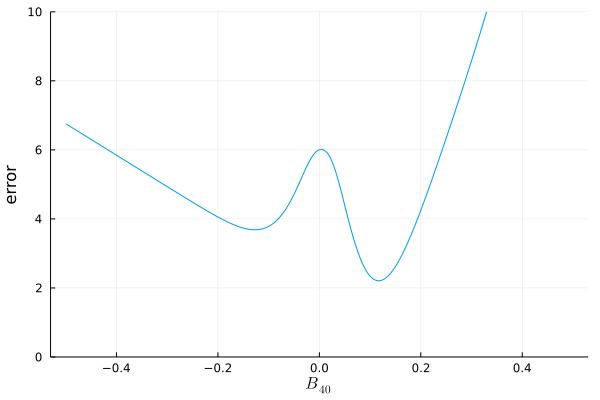

In [403]:
plot(B40_test,error_test_list)
plot!(xlabel=L"B_{40}",ylabel="error")
plot!(ylims = (0,10))
plot!(legend=false)

In [404]:
answer_1,answer_2 = find_error_min(error_test_list)

大域解:0.117
誤差関数の値2.20821041488985
局所解:-0.127
誤差関数の値3.68585342482972


(0.117, -0.127)

# レプリカ, 事前分布パラメータ

In [405]:
function para1()
    L = 35 # レプリカ数
    gamma = 1.5
    C = 0.05
    d = 1.3
    return L, gamma, C, d
end
L, gamma, C, d = para1()

function para2()
    xi = 2
    nu = 0
    return xi,nu
end
xi,nu = para2()

(2, 0)

# 逆温度リスト

In [406]:
function beta_list()
    beta = zeros(L)
    for i in 2:L
        beta[i] = gamma^(i - L)
    end
    return beta
end
beta = beta_list()

35-element Vector{Float64}:
 0.0
 1.5452133483989817e-6
 2.3178200225984725e-6
 3.476730033897709e-6
 5.2150950508465636e-6
 7.822642576269845e-6
 1.1733963864404767e-5
 1.760094579660715e-5
 2.6401418694910726e-5
 3.960212804236609e-5
 5.9403192063549134e-5
 8.910478809532371e-5
 0.00013365718214298556
 ⋮
 0.011561019943888409
 0.017341529915832612
 0.02601229487374892
 0.03901844231062338
 0.05852766346593507
 0.0877914951989026
 0.13168724279835392
 0.19753086419753085
 0.2962962962962963
 0.4444444444444444
 0.6666666666666666
 1.0

# ステップサイズ

In [407]:
function step_list()
    step = ones(L) * C
    for i in 1:L
        if n_total * beta[i]  > 1
            step[i] = C / (n_total * beta[i])^d
        end
    end
    return step
end
step_size = step_list()

35-element Vector{Float64}:
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 ⋮
 0.002579250580043621
 0.001522561697128223
 0.0008987859262293034
 0.0005305638140717238
 0.0003131980069862793
 0.0001848844361008699
 0.0001091394387890664
 6.442628352282562e-5
 3.80315865155368e-5
 2.2450489051976958e-5
 1.3252785509408908e-5
 7.823273842799983e-6

# 事前分布

In [408]:
function prior_list(B40_list)
    prior_40_list = sqrt(xi / 2 * pi) * exp.(- xi * (B40_list .- nu).^2 / 2)
    return prior_40_list
end

prior_list (generic function with 1 method)

# 事前分布 一様分布

In [409]:
function prior_list(B40_list)
    #-2から2までの一様分布
    prob = 1/(2-(-2))
    return ones(length(B40_list))*prob
end

prior_list (generic function with 1 method)

# メトロポリス

In [410]:
# metropolis
function metropolis(B40_list, saitaku)
    B40_proposed = B40_list + rand([-1,1],L) .* step_size
    
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    
    err_proposed = error_list(B40_proposed)
    err_ini = error_list(B40_list)
    error_dif = err_proposed - err_ini
    
    bit_vec = rand(L) .< exp.(- n_total / noise_total * beta .* error_dif) .* prior_ratio
    
    for i in 1:L
        if bit_vec[i] == 0 # 交換しない
            B40_proposed[i] = B40_list[i]
        else #交換
            saitaku[i] += 1
        end
    end
    return B40_proposed, saitaku, err_ini
end

metropolis (generic function with 1 method)

In [411]:
# metropolis(採択率不要ver)
function metropolis_2(B40_list)
    B40_proposed = B40_list + rand([-1,1],L) .* step_size
    
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    
    err_proposed = error_list(B40_proposed)
    err_ini = error_list(B40_list)
    error_dif = err_proposed - err_ini
    
    bit_vec = rand(L) .< exp.(- n_total / noise_total * beta .* error_dif) .* prior_ratio
    for i in 1:L
        if bit_vec[i] == 0 # 交換しない
            B40_proposed[i] = B40_list[i]
        end
    end
    return B40_proposed , err_ini
end

metropolis_2 (generic function with 1 method)

# レプリカ交換

In [412]:
# exchange
function exchange(B40_list, koukann, koukann_total)
    #レプリカからランダムに選択
    l = rand(collect(1:L-1))
    
    beta_dif = beta[l + 1] - beta[l]
    error_dif = error(B40_list[l + 1]) - error(B40_list[l])
    v = exp(n_total / noise_total * beta_dif * error_dif)
    u = minimum([1,v])
    items = [1,0]
    weights = [u,1 - u]
    item = sample(items, Weights(weights)) # 1で交換
    
    #交換
    if item == 1
        B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
        koukann[l] += 1
    end
    
    #レプリカ選択の記録
    koukann_total[l] += 1
    return　B40_list, koukann, koukann_total
end


exchange (generic function with 1 method)

In [413]:
# exchange(交換率不要ver)
function exchange_2(B40_list)
    #レプリカからランダムに選択
    l = rand(collect(1:L-1))
    
    beta_dif = beta[l + 1] - beta[l]
    error_dif = error(B40_list[l + 1]) - error(B40_list[l])
    v = exp(n_total / noise_total * beta_dif * error_dif)
    u = minimum([1,v])
    items = [1,0]
    weights = [u,1 - u]
    item = sample(items, Weights(weights)) # 1で交換
    
    if item == 1
        B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
    end

    return　B40_list
end

exchange_2 (generic function with 1 method)

# EXMC

In [414]:
# exmc
function emc(size_simu, burn_in, frequency_exchange)
    # 初期パラメータ値
    B40_list = nu .+ rand([-1,1],L) .* randn(L) / sqrt(xi)
    
    #格納用(beta=1の値を保存)
    B40_keep = zeros(size_simu-burn_in,L)
    
    #採択率,交換率記録
    saitaku = zeros(L)
    koukann = zeros(L)
    koukann_total = zeros(L)
    
    #各温度誤差関数の値記録
    error_func_list = zeros(size_simu,L)
    
    # 更新
    p = Progress(burn_in; showspeed=true)
    q = Progress(size_simu-burn_in; showspeed=true)
    
    #バーンイン区間
    for iter in 1:burn_in
        B40_list, error_ini = metropolis_2(B40_list)
        error_func_list[iter,:] = error_ini
        
        if iter % frequency_exchange == 0
            B40_list = exchange_2(B40_list)
        end
        
        ProgressMeter.next!(p)
    end
    
    #バーンイン終了後
    for iter in 1:size_simu-burn_in
        B40_list, saitaku, error_ini = metropolis(B40_list, saitaku)
        error_func_list[iter + burn_in, :] = error_ini
        
        if iter % frequency_exchange == 0
            B40_list, koukann = exchange(B40_list, koukann,koukann_total)
        end
        
        B40_keep[iter,:] = B40_list
        ProgressMeter.next!(q)
    end
    
    
    saitaku = saitaku / size_simu
    koukann = koukann ./ koukann_total
    
    return B40_keep,saitaku,koukann, error_func_list
end

emc (generic function with 1 method)

In [415]:
B40_list,saitaku,koukann,error_func_list = emc(70000, 35000, 2)

Progress: 100%|███████████████████████████| Time: 0:58:16 ( 0.10  s/it)
Progress: 100%|███████████████████████████| Time: 1:55:43 ( 0.20  s/it)mt)m


([-6.171704259973397 -8.442315886372974 … 0.11796278793446291 0.11505802074742272; -6.121704259973397 -8.392315886372973 … 0.1179495351489535 0.11505019747357992; … ; 15.89086669520244 -9.507385831443045 … 0.1196882832904827 0.11706221269785842; 15.84086669520244 -9.457385831443045 … 0.11967503050497329 0.11707003597170122], [0.5, 0.4997714285714286, 0.4997, 0.49947142857142857, 0.4993142857142857, 0.49882857142857145, 0.4984857142857143, 0.49815714285714285, 0.4977714285714286, 0.49744285714285713  …  0.47341428571428573, 0.4820714285714286, 0.48697142857142856, 0.49104285714285717, 0.4931, 0.4951285714285714, 0.4971, 0.49752857142857143, 0.49794285714285713, 0.49842857142857144], [0.8392523364485981, 0.9332129963898917, 0.9152542372881356, 0.90625, 0.906187624750499, 0.9503968253968254, 0.9550561797752809, 0.9577735124760077, 0.972972972972973, 0.9501084598698482  …  0.8840304182509505, 0.8713450292397661, 0.8693877551020408, 0.8786127167630058, 0.8799212598425197, 0.8550106609808102

In [416]:
error_func_list

70000×35 Matrix{Float64}:
   5.07062   5.23335  4.84322  10.0906  …  4.10252  57.4611   3.71184
   4.617     5.89894  3.81962  10.413      4.1027   57.4596   3.71181
   4.17684   5.23335  4.84322  10.7199     4.10289  57.4581   3.71184
   3.80852   3.96063  6.01099  10.413      4.1027   57.4581   3.71186
   3.69046   4.17684  4.14495  10.7199     4.10252  57.4581   3.71189
   3.96063   3.80852  6.01099  10.413   …  4.10252  57.4581   3.71186
   3.69046   4.17684  4.14495  10.0906     4.1027   57.4581   3.71184
   3.93144   4.617    6.01099  10.413      4.10289  57.4566   3.71186
   3.69046   4.17684  4.84322  10.7199     4.1027   57.4552   3.71189
   3.93144   4.617    6.01099  10.413      4.10289  57.4537   3.71186
   3.69046   5.07062  4.84322  10.7199  …  4.1027   57.4537   3.71184
   3.93144   4.617    6.01099  11.0121     4.10289  57.4552   3.71186
   4.33955   5.07062  4.14495  11.2901     4.10307  57.4537   3.71189
   ⋮                                    ⋱                     
 

In [443]:
error_func_check = error_func_list[35000+1:end,1:end-1]

35000×34 Matrix{Float64}:
  18.5018  19.1376  224.407    11.8222  …  2.22379  2.21555  2.20904  2.20865
  18.5199  19.1277  221.747    12.0616     2.22414  2.21569  2.20901  2.20867
  18.5018  19.1176  219.033    12.2898     2.22449  2.21583  2.20898  2.20865
  18.4835  19.1277  221.747    12.0616     2.22484  2.21569  2.20896  2.20864
  18.5018  19.1376  219.033    12.2898     2.2252   2.21583  2.20893  2.20979
  18.4835  19.1277  221.747    12.0616  …  2.22556  2.21597  2.20896  2.20981
  18.4648  19.1376  219.033    12.2898     2.2252   2.21583  2.20898  2.20983
  18.4459  19.1474  221.747    12.5074     2.2252   2.21597  2.20901  2.20986
  18.4648  19.1571  224.407    12.2898     2.22556  2.21583  2.20983  2.20904
  18.4459  19.1667  221.747    12.0616     2.2252   2.21597  2.20987  2.20905
  18.4267  19.1762  219.033    11.8222  …  2.22484  2.21583  2.20983  2.20904
  18.4072  19.1667  216.264    11.5709     2.22449  2.21569  2.20987  2.20902
  18.4267  19.1571  219.033    11.307 

In [442]:
beta_dif = beta[2:end] - beta[1:end-1]

34-element Vector{Float64}:
 1.5452133483989817e-6
 7.726066741994908e-7
 1.1589100112992364e-6
 1.7383650169488547e-6
 2.6075475254232814e-6
 3.911321288134922e-6
 5.866981932202384e-6
 8.800472898303575e-6
 1.3200709347455363e-5
 1.9801064021183045e-5
 2.9701596031774574e-5
 4.4552394047661854e-5
 6.682859107149278e-5
 ⋮
 0.0038536733146294693
 0.005780509971944204
 0.008670764957916306
 0.013006147436874463
 0.019509221155311687
 0.02926383173296753
 0.04389574759945132
 0.06584362139917693
 0.09876543209876543
 0.14814814814814814
 0.2222222222222222
 0.33333333333333337

In [446]:
for replica in 1:L-1
    error_func_check[:,replica] *= beta_dif[replica]
end

In [447]:
error_func_check

35000×34 Matrix{Float64}:
 2.85893e-5   1.47858e-5  0.000260068  …  0.32823   0.490897  0.736218
 2.86172e-5   1.47782e-5  0.000256985     0.328251  0.490891  0.736222
 2.85893e-5   1.47704e-5  0.000253839     0.328271  0.490885  0.736218
 2.85609e-5   1.47782e-5  0.000256985     0.328251  0.490879  0.736214
 2.85893e-5   1.47858e-5  0.000253839     0.328271  0.490873  0.736596
 2.85609e-5   1.47782e-5  0.000256985  …  0.328293  0.490879  0.736604
 2.85321e-5   1.47858e-5  0.000253839     0.328271  0.490885  0.736611
 2.85029e-5   1.47934e-5  0.000256985     0.328293  0.490891  0.736619
 2.85321e-5   1.48009e-5  0.000260068     0.328271  0.491074  0.736345
 2.85029e-5   1.48084e-5  0.000256985     0.328293  0.491083  0.736351
 2.84732e-5   1.48157e-5  0.000253839  …  0.328271  0.491074  0.736345
 2.8443e-5    1.48084e-5  0.000250631     0.328251  0.491083  0.73634
 2.84732e-5   1.48009e-5  0.000253839     0.328271  0.491091  0.736335
 ⋮                                     ⋱            

In [448]:
error_func_check *=  n_total / noise_total

35000×34 Matrix{Float64}:
 0.0266052  0.0137597  0.242019    …  204.391  305.451  456.829  685.125
 0.0266312  0.0137526  0.23915        204.423  305.47   456.823  685.128
 0.0266052  0.0137454  0.236223       204.455  305.489  456.818  685.125
 0.0265788  0.0137526  0.23915        204.488  305.47   456.812  685.121
 0.0266052  0.0137597  0.236223       204.521  305.489  456.807  685.476
 0.0265788  0.0137526  0.23915     …  204.554  305.509  456.812  685.483
 0.026552   0.0137597  0.236223       204.521  305.489  456.818  685.49
 0.0265248  0.0137668  0.23915        204.521  305.509  456.823  685.497
 0.026552   0.0137737  0.242019       204.554  305.489  456.994  685.243
 0.0265248  0.0137807  0.23915        204.521  305.509  457.002  685.248
 0.0264972  0.0137875  0.236223    …  204.488  305.489  456.994  685.243
 0.0264691  0.0137807  0.233237       204.455  305.47   457.002  685.238
 0.0264972  0.0137737  0.236223       204.455  305.489  457.01   685.233
 ⋮                        

In [452]:
free_energy_for_replica = zeros(L-1)
for replica in 1:L-1
    free_energy_for_replica[replica] = sum(error_func_check[:,replica])
end

In [457]:
free_energy_for_replica /=  size(error_func_check)[1]

34-element Vector{Float64}:
   0.28193999155184224
   0.11183780036009672
   0.13686605089398265
   0.15464442366234538
   0.15806416239909682
   0.1325188069022764
   0.13926949289859555
   0.17125626116780512
   0.23775490246985734
   0.29876463579562684
   0.424270910039663
   0.6164466952726428
   0.8295216159614848
   ⋮
   8.161978133614637
  12.14180697065045
  18.065835763873952
  26.98024777878086
  40.32791620918353
  60.338211313173666
  90.42003465721687
 135.53117779668153
 203.18508212160762
 304.6192809750191
 456.85917241354565
 685.2165715618036

In [458]:
sum(free_energy_for_replica)

2065.828833705587

In [449]:
n_total/noise_total

930.6

In [450]:
n/noise_chi

35.0

In [451]:
m/noise_spc

496.0

# free energy

In [417]:
function find_free_energy(error_func_list,burn_in)
    #バーンイン後のエネルギー関数抽出
    error_func_check = error_func_list[burn_in+1:end,1:end-1]
    
    #温度差
    beta_dif = beta[2:end] - beta[1:end-1]
    
    #温度差をかける
    for replica in 1:L-1
        error_func_check[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error_func_check *= - n_total / noise_total
    
    #最大値取得
    error_func_check_max = zeros(L-1)
    for replica in 1:L-1
        error_func_check_max[replica] = maximum(error_func_check[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_func_check_dif = copy(error_func_check)
    for replica in 1:L-1
        error_func_check_dif[:,replica] = error_func_check[:,replica] .- error_func_check_max[replica]
    end
    
    #期待値計算
    log_exp_sum = zeros(L-1)
    for replica in 1:L-1
        log_exp_sum[replica] = log(sum(exp.(error_func_check_dif)[:,replica]))
    end
    
    #各レプリカでの自由エネルギー期待値
    free_energy_for_replica = -(- log( size(error_func_list)[1] - burn_in ) .+  error_func_check_max .+ log_exp_sum)
    
    #最終的な自由エネルギー(足し算)
    free_energy = sum(free_energy_for_replica)
    
    return error_func_check,free_energy
end

find_free_energy (generic function with 1 method)

In [418]:
a = Vector(1:5000:65000)
b = Vector(10000:5000:70000)

free_energy_list = zeros(length(a))

#バーンイン後のエネルギー関数抽出
for i in 1:length(a)
    error_func_check = error_func_list[a[i]:b[i],:]
    -,free_energy_list[i] = find_free_energy(error_func_check,0)
end

In [419]:
free_energy_list

13-element Vector{Float64}:
 2066.527247412877
 2064.8253996462145
 2064.531106614785
 2063.848256209572
 2063.501136694372
 2063.3680543319815
 2063.868133143161
 2063.6333316389255
 2063.7188015277948
 2064.3584264199344
 2064.437646892762
 2063.9514028936364
 2063.5689534367402

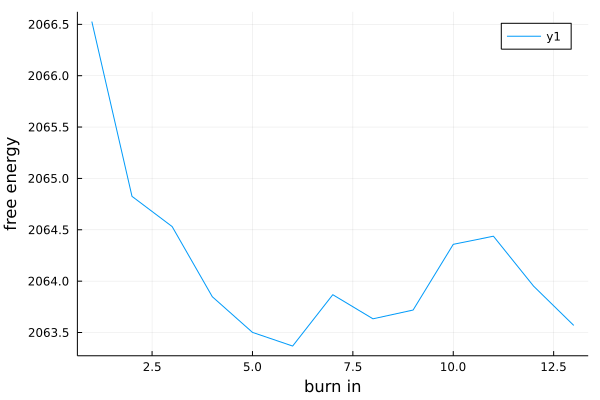

In [482]:

plot(free_energy_list)
plot!(xlabel = "burn in", ylabel="free energy")

In [483]:
savefig("/Users/nishimurarei/home/lab/data/211004/free_energy_int.pdf")

In [421]:
error_func_check_int,free_energy_int = find_free_energy(error_func_list,35000)

([-0.02660516850357213 -0.013759708683886838 … -456.82864014223117 -685.1246539527032; -0.026631161335743968 -0.013752570994174271 … -456.82305989239995 -685.1283002370233; … ; -0.5907551889090892 -0.013883416628471285 … -456.695673720242 -686.0135218064522; -0.5910310817709987 -0.013889175024772361 … -456.69307234542555 -686.00374285942], 2063.894711384894)

In [351]:
print("統合後の自由エネルギー:",free_energy_int)

統合後の自由エネルギー:2064.558848120092

In [260]:
error_func_check_int

25000×29 Matrix{Float64}:
 -1.17478  -0.662787  -0.944553  -0.632433  …  -112.062  -156.962  -219.657
 -1.06686  -0.662787  -0.751721  -0.632433     -112.062  -157.154  -219.657
 -1.42178  -0.662787  -0.944553  -0.714522     -112.104  -156.962  -219.757
 -1.06686  -0.662787  -0.751721  -0.714522     -112.062  -156.882  -219.657
 -1.42178  -0.536943  -0.736369  -0.714522     -112.062  -156.915  -219.633
 -1.06686  -0.674681  -0.626562  -0.632433  …  -112.19   -156.882  -219.657
 -1.6867   -0.469914  -0.626562  -0.714522     -112.062  -156.962  -219.757
 -1.34236  -0.469914  -0.626562  -1.29098      -112.104  -156.962  -219.932
 -1.6867   -0.469914  -0.736369  -0.714522     -112.317  -156.882  -219.932
 -1.34236  -0.426744  -0.626562  -0.714522     -112.104  -156.882  -220.182
 -1.6867   -0.426744  -0.736369  -0.714522  …  -112.317  -156.915  -219.932
 -1.6867   -0.469914  -0.626562  -0.714522     -112.317  -157.062  -219.757
 -5.61361  -0.469914  -0.626562  -0.714522     -112.701  -157.

# 採択率と交換率

In [422]:
df = DataFrame(
           beta_list=beta,
           採択率_B40=saitaku,
           交換率=koukann)

,beta_list,採択率_B40,交換率
,Float64,Float64,Float64
1,0.0,0.5,0.839252
2,1.54521e-6,0.499771,0.933213
3,2.31782e-6,0.4997,0.915254
4,3.47673e-6,0.499471,0.90625
5,5.2151e-6,0.499314,0.906188
6,7.82264e-6,0.498829,0.950397
7,1.1734e-5,0.498486,0.955056
8,1.76009e-5,0.498157,0.957774
9,2.64014e-5,0.497771,0.972973


In [423]:
df |> CSV.write("/Users/nishimurarei/home/lab/data/211004/vin_int.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/211004/vin_int.csv"

# 全てのレプリカの事後分布

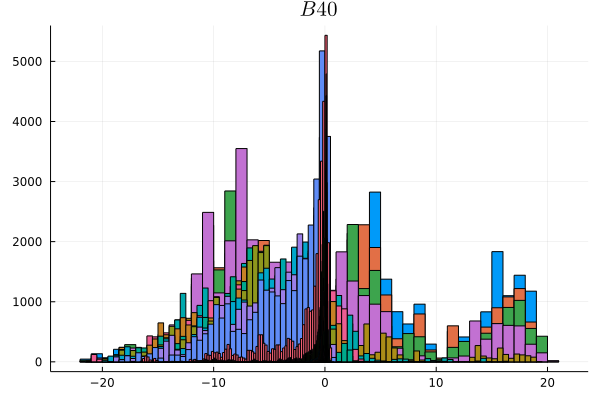

In [424]:
plot(B40_list,st=:histogram)
plot!(title=L"B40")
plot!(legend=false)
#plot!(answer_1*ones(1500),collect(1:1500), linestyle=:dot,linewidth = 5,label="true value")

In [425]:
savefig("/Users/nishimurarei/home/lab/data/211004/hist_all_int.pdf")

In [426]:
#logスケール

#=
plot(B40_list,st=:histogram,yaxis=:log)
plot!(title=L"B40")
#plot!(B40_test,-10.^error_test_list)
#plot!(answer_1*ones(1500),collect(1:1500), linestyle=:dot,linewidth = 5,label="true value")
=#

# beta=1のレプリカの事後分布

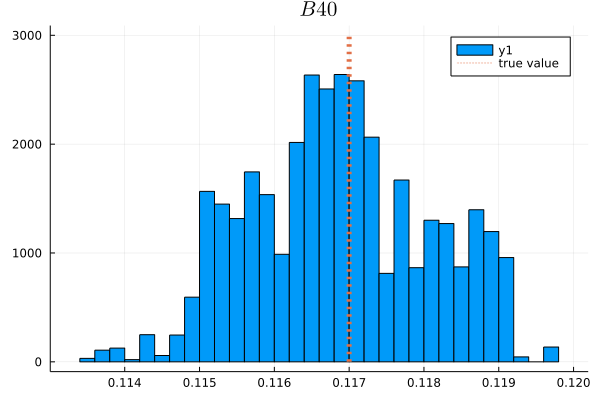

In [428]:
plot(B40_list[:,end],st=:histogram)
plot!(title=L"B40")
plot!(answer_1*ones(3000),collect(1:3000), linestyle=:dot,linewidth = 5,label="true value")

In [429]:
savefig("/Users/nishimurarei/home/lab/data/211004/integrate_hist.pdf")

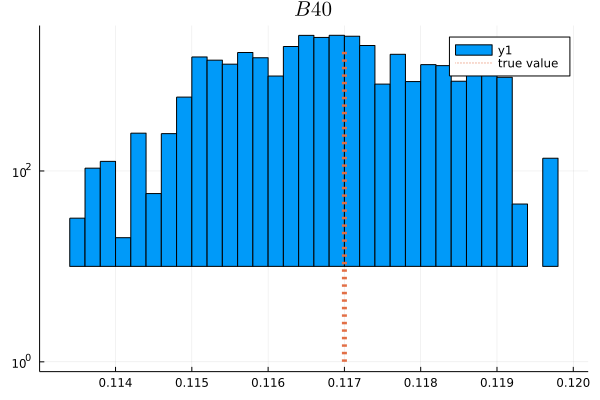

In [430]:
#logスケール

plot(B40_list[:,end],st=:histogram,yaxis=:log)
plot!(title=L"B40")
plot!(answer_1*ones(2000),collect(1:2000), linestyle=:dot,linewidth = 5,label="true value")

# 特定のレプリカの事後分布

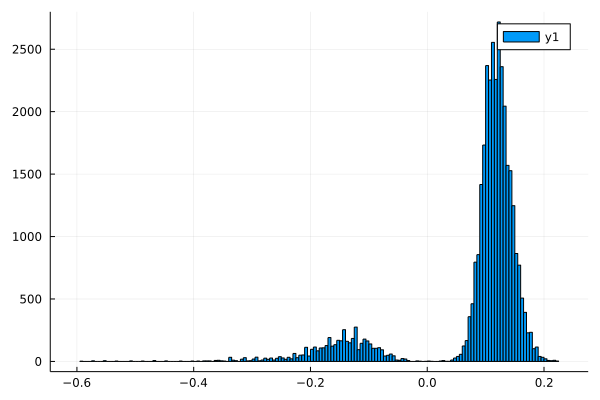

In [431]:
histogram(B40_list[:,20])

In [432]:
#savefig("/Users/nishimurarei/home/lab/data/210922/spc/spc_hist.pdf")

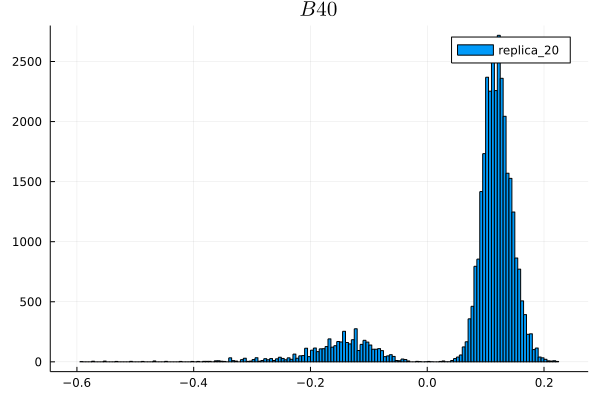

In [433]:
plot(B40_list[:,20],st=:histogram,label="replica_20")
plot!(title=L"B40")

In [434]:
savefig("/Users/nishimurarei/home/lab/data/211004/hist_int_20.pdf")

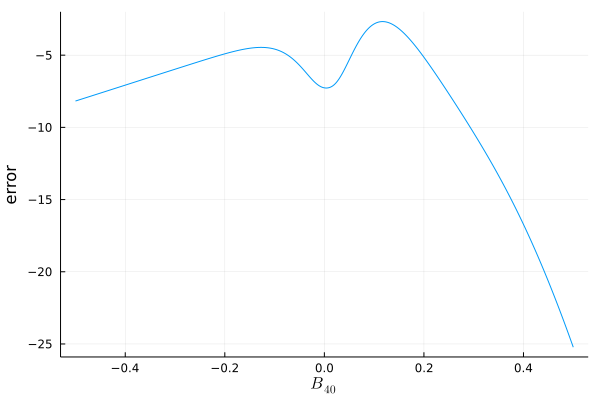

In [368]:
#誤差関数反転
plot(B40_test,-error_test_list)
plot!(xlabel=L"B_{40}",ylabel="error")
plot!(legend=false)

In [369]:
#savefig("/Users/nishimurarei/home/lab/data/210930/error_inverse.pdf")

# 誤差関数最小のパラメータ探索

In [242]:
function error_min_find(B40_list)
    error_list = zeros(length(B40_list))
    @threads for i in 1:length(B40_list)
        error_list[i] = error(B40_list[i])
    end
    estimate_para = B40_list[argmin(error_list)]
    return estimate_para
end

error_min_find (generic function with 1 method)

In [243]:
estimate_para = error_min_find(B40_list)
println("estimate parameter:",estimate_para)

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90;4mboot.jl:448[0m[90m [inlined][39m
      [2] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90;4marray.jl:357[0m[90m [inlined][39m
      [3] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90;4marray.jl:809[0m[90m [inlined][39m
      [4] [0m[1msyevr![22m[0m[1m([22m[90mjobz[39m::[0mChar, [90mrange[39m::[0mChar, [90muplo[39m::[0mChar, [90mA[39m::[0mMatrix[90m{Float64}[39m, [90mvl[39m::[0mFloat64, [90mvu[39m::[0mFloat64, [90mil[39m::[0mInt64, [90miu[39m::[0mInt64, [90mabstol[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[35mLinearAlgebra.LAPACK[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/[39m[90;4mlapack.jl:5128[0m
      [5] [0m[1m#eigen!#99[22m
    [90m    @ [39m[90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/[39m[90;4msymmetric.jl:675[0m[90m [inlined][39m
      [6] [0m[1meigen![22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m; [90mpermute[39m::[0mBool, [90mscale[39m::[0mBool, [90msortby[39m::[0mtypeof(LinearAlgebra.eigsortby)[0m[1m)[22m
    [90m    @ [39m[35mLinearAlgebra[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/[39m[90;4meigen.jl:151[0m
      [7] [0m[1meigen[22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m; [90mpermute[39m::[0mBool, [90mscale[39m::[0mBool, [90msortby[39m::[0mtypeof(LinearAlgebra.eigsortby)[0m[1m)[22m
    [90m    @ [39m[35mLinearAlgebra[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/[39m[90;4meigen.jl:237[0m
      [8] [0m[1meigen[22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mLinearAlgebra[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/[39m[90;4meigen.jl:235[0m
      [9] [0m[1mchi[22m[0m[1m([22m[90mOnn[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mIn[8]:16[0m
     [10] [0m[1merror_chi[22m[0m[1m([22m[90mB40[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mIn[64]:2[0m
     [11] [0m[1merror[22m[0m[1m([22m[90mB40[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mIn[72]:2[0m
     [12] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90;4mIn[242]:4[0m[90m [inlined][39m
     [13] [0m[1m(::var"#236#threadsfor_fun#13"{Matrix{Float64}, Vector{Float64}, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [14] [0m[1m(::var"#236#threadsfor_fun#13"{Matrix{Float64}, Vector{Float64}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

# 推定パラメータによるプロット

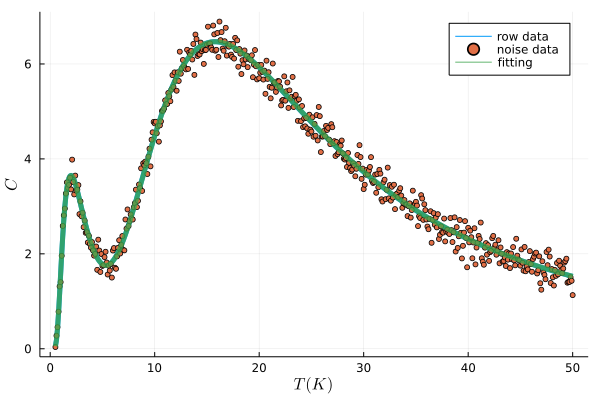

In [298]:
#比熱
plot(Temp_table_spc,SpcHeat_Temp, linewidth = 5, label = "row data")
plot!(Temp_table_spc,SpcHeat_Temp_noise,st = :scatter,markersize = 3, label = "noise data")
plot!(Temp_table_spc,spc(Onn_make(estimate_para)),linewidth = 5, alpha = 0.8, label = "fitting")
plot!(xlabel=L"T(K)",ylabel=L"C")

In [299]:
savefig("/Users/nishimurarei/home/lab/data/210930/result_spc.pdf")

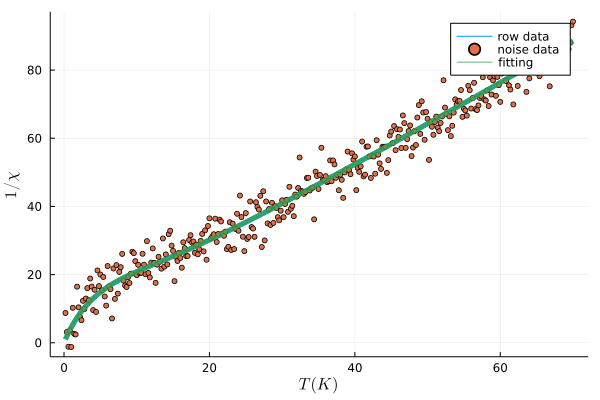

In [300]:
# 比熱
plot(Temp_table_chi,chi_inv_Temp, linewidth = 5, label = "row data")
plot!(Temp_table_chi,chi_inv_Temp_noise,st = :scatter,markersize = 3, label = "noise data")
plot!(Temp_table_chi,chi(Onn_make(estimate_para)),linewidth = 5, alpha = 0.8, label = "fitting")
plot!(xlabel=L"T(K)",ylabel=L"1/\chi")

In [301]:
savefig("/Users/nishimurarei/home/lab/data/210930/result_chi.pdf")

# B40データ保存

In [435]:
df_data = DataFrame(B40=B40_list[:,end])

,B40
,Float64
1,0.115058
2,0.11505
3,0.115042
4,0.117923
5,0.117915
6,0.117923
7,0.117915
8,0.117907
9,0.1179


In [436]:
df_data |> CSV.write("/Users/nishimurarei/home/lab/data/211004/int.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/211004/int.csv"

# 統合

In [437]:
B40_list_spc = CSV.read("/Users/nishimurarei/home/lab/data/211004/spc.csv", DataFrame)

,B40
,Float64
1,0.1171
2,0.117084
3,0.1171
4,0.117116
5,0.117131
6,0.117147
7,0.117131
8,0.117116
9,0.1171


In [438]:
B40_list_spc = B40_list_spc.B40

25000-element SentinelArrays.ChainedVector{Float64, Vector{Float64}}:
 0.11710002015027822
 0.11708435827270228
 0.11710002015027822
 0.11711568202785416
 0.1171313439054301
 0.11714700578300605
 0.1171313439054301
 0.11711568202785416
 0.11710002015027822
 0.11708435827270228
 0.11706869639512633
 0.11705303451755039
 0.11706869639512633
 ⋮
 0.11628939504253674
 0.11630505692011268
 0.11632071879768863
 0.11630505692011268
 0.11628939504253674
 0.1162737331649608
 0.11628939504253674
 0.11630505692011268
 0.11632071879768863
 0.11633638067526457
 0.11635204255284051
 0.11636770443041645

In [439]:
B40_list_chi_df = CSV.read("/Users/nishimurarei/home/lab/data/211004/chi.csv", DataFrame)

,B40
,Float64
1,0.122994
2,0.123019
3,0.122994
4,0.122969
5,0.122994
6,0.123019
7,0.123043
8,0.123068
9,0.123092


In [440]:
B40_list_chi = B40_list_chi_df.B40

35000-element SentinelArrays.ChainedVector{Float64, Vector{Float64}}:
 0.12299387164932653
 0.12301851396670224
 0.12299387164932653
 0.12296922933195081
 0.12299387164932653
 0.12301851396670224
 0.12304315628407796
 0.12306779860145367
 0.12309244091882938
 0.12306779860145367
 0.12304315628407796
 0.12151623151355016
 0.12154087383092588
 ⋮
 0.12636076646674954
 0.12633612414937384
 0.12636076646674954
 0.12638540878412524
 0.12641005110150094
 0.12643469341887664
 0.12641005110150094
 0.12643469341887664
 0.12641005110150094
 0.12279245011067644
 0.12276780779330072
 0.12279245011067644

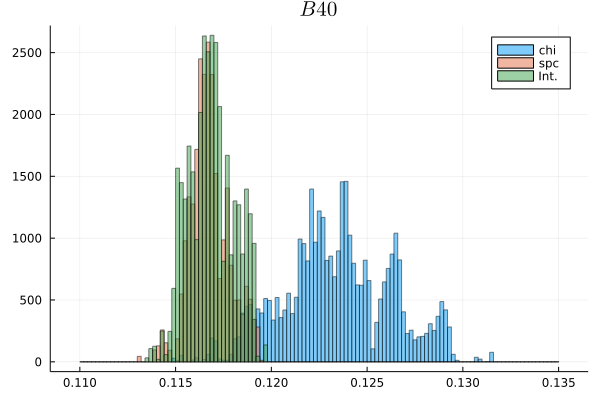

In [484]:
plot(B40_list_chi,st=:histogram,alpha=0.5,label="chi",bin=range(0.11, 0.135, step=0.0002))
plot!(B40_list_spc,st=:histogram,alpha=0.5,label="spc",bin=range(0.11, 0.135, step=0.0002))
plot!(B40_list[:,end],st=:histogram,alpha=0.5,label="Int.",bin=range(0.11, 0.135, step=0.0002))
plot!(title=L"B40")
#plot!(answer_1*ones(1500),collect(1:1500), linestyle=:dot,linewidth = 5,label="true value")

In [485]:
savefig("/Users/nishimurarei/home/lab/data/211004/int.pdf")

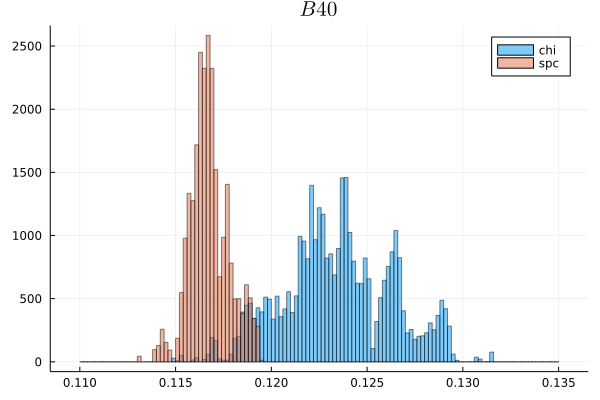

In [486]:
plot(B40_list_chi,st=:histogram,alpha=0.5,label="chi",bin=range(0.11, 0.135, step=0.0002))
plot!(B40_list_spc,st=:histogram,alpha=0.5,label="spc",bin=range(0.11, 0.135, step=0.0002))
#plot!(B40_list[:,end],st=:histogram,alpha=0.5,label="Int.",bin=range(0.11, 0.135, step=0.0002))
plot!(title=L"B40")
#plot!(answer_1*ones(1500),collect(1:1500), linestyle=:dot,linewidth = 5,label="true value")

In [487]:
savefig("/Users/nishimurarei/home/lab/data/211004/int_chi_spc.pdf")

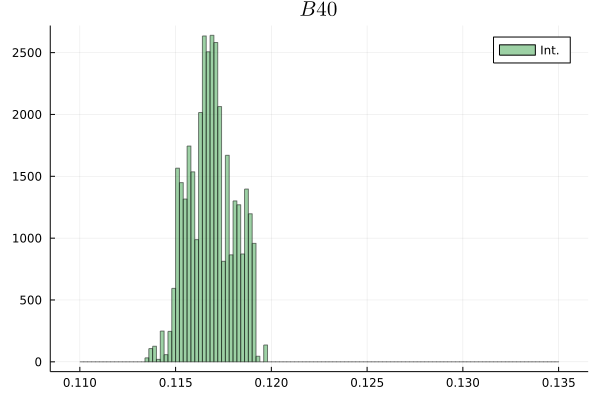

In [488]:
#plot(B40_list_chi,st=:histogram,alpha=0.5,label="chi",bin=range(0.11, 0.135, step=0.0002))
#plot!(B40_list_spc,st=:histogram,alpha=0.5,label="spc",bin=range(0.11, 0.135, step=0.0002))
plot(B40_list[:,end],st=:histogram,alpha=0.5,label="Int.",bin=range(0.11, 0.135, step=0.0002),color=palette(:default)[3])
plot!(title=L"B40")
#plot!(answer_1*ones(1500),collect(1:1500), linestyle=:dot,linewidth = 5,label="true value")


In [489]:
savefig("/Users/nishimurarei/home/lab/data/211004/int_int.pdf")